In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import random

import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision import models, datasets
import torch.nn.functional as F
from PIL import Image

import helper

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [45]:
train_path = './train/train'
train_dir = os.listdir(train_path)

random.shuffle(train_dir)
train_image_paths = train_dir[5000:]
val_image_paths = train_dir[:5000]

In [10]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, paths, phase='train') -> None:
        super().__init__()
        self.paths = paths
        self.phase = phase
        self.image_dir = image_dir
        self.transform = {}
        self.transform['validation'] = transforms.Compose([
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        self.transform['train'] = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.paths[index])
        img = Image.open(image_path)
        if self.phase == 'train':
            img = self.transform['train'](img)
        else:
            img = self.transform['validation'](img)

        label = self.paths[index][:3]
        return img, int(label == 'cat')
    
    def __len__(self):
        return len(self.paths)


In [66]:
train_data = ImageDataset(train_path, train_image_paths, 'train')
val_data = ImageDataset(train_path, val_image_paths, 'validation')

train_loader = DataLoader(train_data, shuffle=True, batch_size=64)
val_loader = DataLoader(val_data, shuffle=False, batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3935575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.186841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


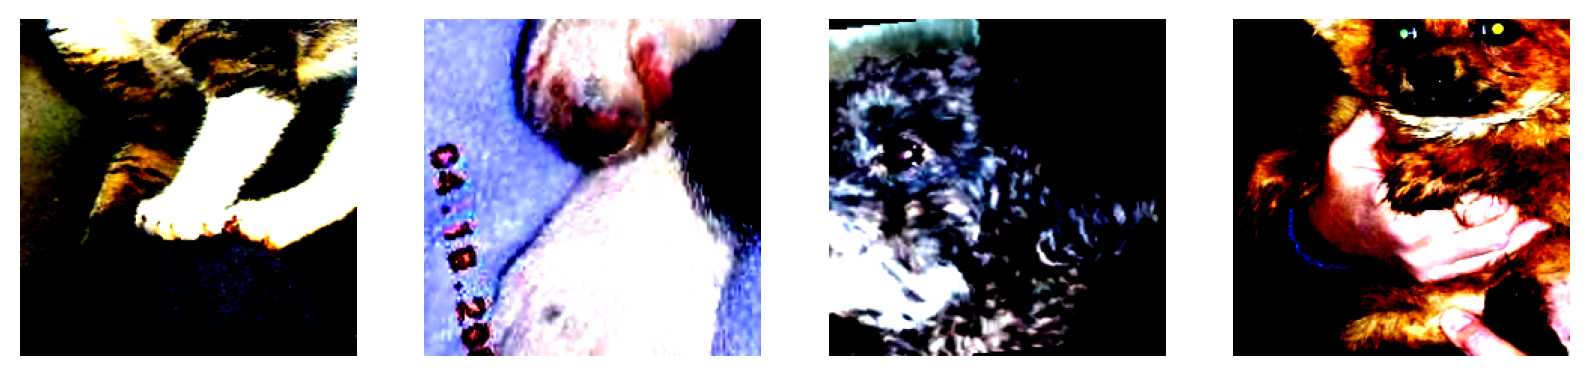

In [67]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)

for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

In [4]:
model = models.densenet121(pretrained=True)
model

c:\Users\aakash.sorathiya\Desktop\kaggle\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aakash.sorathiya\Desktop\kaggle\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(1024, 512)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(512, 2)),
        ('output', nn.LogSoftmax(dim=1))
    ])
)
classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)

In [6]:
model.classifier = classifier
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [68]:
lr = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

In [70]:
epoch = 10
model.to(device)
train_losses = []
val_losses = []
best_acc = 0

for e in range(epoch):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                predictions = model.forward(images)
                loss = criterion(predictions, labels)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
            else:
                train_losses.append(train_loss/len(train_loader))
                print(f"Avg Train Loss: {train_loss/len(train_loader)}, Epoch: {e+1}")
        elif phase == 'validation':
            model.eval()
            val_loss = 0
            val_acc = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)

                    predictions = model.forward(images)
                    loss = criterion(predictions, labels)
                    val_loss += loss.item()

                    y_pred = torch.exp(predictions)
                    top_p, top_class = y_pred.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    acc = torch.mean(equals.type(torch.FloatTensor))
                    val_acc += acc
                else:
                    val_losses.append(val_loss/len(val_loader))
                    epoch_acc = val_acc/len(val_loader)
                    if epoch_acc>best_acc:
                        best_acc=epoch_acc
                        torch.save(model.state_dict(), 'best_model.pth')
                    print(f"Avg Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_acc/len(val_loader)}, Epoch: {e+1}")

Avg Train Loss: 0.12491063834331669, Epoch: 1
Avg Val Loss: 0.05513889814102197, Val Accuracy: 0.9804192781448364, Epoch: 1
Avg Train Loss: 0.12943484254490834, Epoch: 2
Avg Val Loss: 0.05103204129381648, Val Accuracy: 0.981210470199585, Epoch: 2
Avg Train Loss: 0.12266060069631844, Epoch: 3
Avg Val Loss: 0.05222343878608338, Val Accuracy: 0.9816060066223145, Epoch: 3
Avg Train Loss: 0.1289455507652828, Epoch: 4
Avg Val Loss: 0.05077389602938408, Val Accuracy: 0.981210470199585, Epoch: 4
Avg Train Loss: 0.12079200834131089, Epoch: 5
Avg Val Loss: 0.05130094899265449, Val Accuracy: 0.9808148741722107, Epoch: 5
Avg Train Loss: 0.12615951281576493, Epoch: 6
Avg Val Loss: 0.055912197331744656, Val Accuracy: 0.9800237417221069, Epoch: 6
Avg Train Loss: 0.12377961081104538, Epoch: 7
Avg Val Loss: 0.050143270093146, Val Accuracy: 0.981210470199585, Epoch: 7
Avg Train Loss: 0.12387383301941732, Epoch: 8
Avg Val Loss: 0.053183533298441124, Val Accuracy: 0.9808148741722107, Epoch: 8
Avg Train Lo

In [7]:
best_model_state = torch.load('best_model.pth')
model.load_state_dict(best_model_state)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

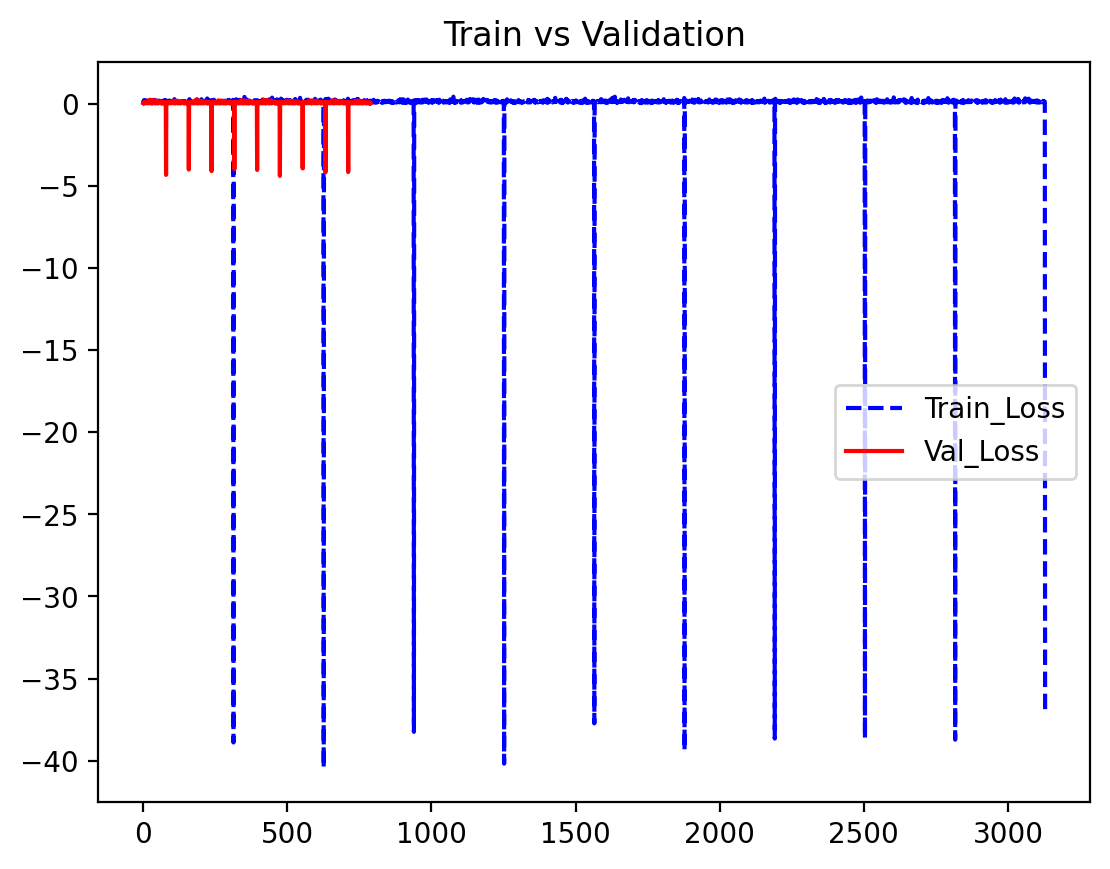

In [78]:
plt.plot(train_losses, 'b--', label='Train_Loss')
plt.plot(val_losses, 'r-', label='Val_Loss')
plt.title('Train vs Validation')
plt.legend()
plt.show()

In [11]:
test_dir = './test1/'
test_paths = os.listdir(test_dir)

test_data = ImageDataset(test_dir, test_paths, 'test')
test_loader = DataLoader(test_data, batch_size=64)

model.to(device)

In [20]:
test_labels = []
for images, _ in test_loader:
    images = images.to(device)
    predictions = model.forward(images)
    y_pred = torch.exp(predictions)
    top_p, top_class = y_pred.topk(1, dim=1)
    for cls in top_class:
        test_labels.append(cls[0].item())

In [22]:
len(test_labels)

12500

In [25]:
result = pd.DataFrame({'label': test_labels})
result.index = range(1, result.shape[0]+1)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 1 to 12500
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   12500 non-null  int64
dtypes: int64(1)
memory usage: 97.8 KB


In [26]:
result.to_csv('submission.csv', index_label='id')